In [1]:
import pandas as pd
import numpy as np
import seaborn as sn
from suntime import Sun
import pytz
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
import optuna
pd.set_option('display.float_format', lambda x: '%.8f' % x)

# Helper Functions

In [2]:
def datetime_index(dataframe):
    dataframe.columns = dataframe.columns.str.replace(' ', '')
    dataframe['Datetime'] = pd.to_datetime(dataframe['DateTime'])
    dataframe = dataframe.set_index(['Datetime'])
    del dataframe['DateTime']
    return dataframe

def fill_na(dataframe):
    dataframe['WWCode'] = dataframe['WWCode'].fillna(0).astype(int)
    return dataframe

def day_night(dataframe):

    coordinates = [40.239, 33.029] # Ankara
    dataframe['datetime_col'] = dataframe.index
    
    dataframe["Date"] = dataframe['datetime_col'].apply(pd.to_datetime).dt.date.apply(str)
    dataframe["Hour"] = dataframe['datetime_col'].apply(pd.to_datetime).dt.hour
    dataframe["Day_of_Week"] = dataframe['datetime_col'].apply(pd.to_datetime).dt.dayofweek
    dataframe["Quarter"] = dataframe['datetime_col'].apply(pd.to_datetime).dt.quarter
    dataframe["Month"] = dataframe['datetime_col'].apply(pd.to_datetime).dt.month
    dataframe["Year"] = dataframe['datetime_col'].apply(pd.to_datetime).dt.year
    dataframe["Day_of_Year"] = dataframe['datetime_col'].apply(pd.to_datetime).dt.dayofyear
    dataframe["Week"] = dataframe['datetime_col'].apply(pd.to_datetime).dt.week
    dataframe["Week_of_Year"] = dataframe['datetime_col'].apply(pd.to_datetime).dt.weekofyear
    
    sun = Sun(coordinates[0], coordinates[1])
    tz =pytz.timezone('Europe/Istanbul')
    dataframe["Day"]= dataframe[["Date","Hour"]].apply(lambda x : sun.get_local_sunrise_time(pd.to_datetime(x["Date"]).
                                                                date(),local_time_zone=tz).
                                         hour <= x["Hour"] <= sun.get_local_sunset_time(pd.to_datetime(x["Date"]).
                                                                date(),local_time_zone=tz).hour ,axis=1)
    dataframe = dataframe.drop(['Date', 'datetime_col'], axis = 1)
    return dataframe

def wwcode_encoder(dataframe):
    for index, row in dataframe.iterrows():
        if row['WWCode'] < 10:
            dataframe.loc[index, 'WWCode'] = 1
        elif row['WWCode'] < 20:
            dataframe.loc[index, 'WWCode'] = 2
        elif row['WWCode'] < 30:
            dataframe.loc[index, 'WWCode'] = 3
        elif row['WWCode'] < 40:
            dataframe.loc[index, 'WWCode'] = 4
        elif row['WWCode'] < 50:
            dataframe.loc[index, 'WWCode'] = 5
        elif row['WWCode'] < 60:
            dataframe.loc[index, 'WWCode'] = 6
        elif row['WWCode'] < 70:
            dataframe.loc[index, 'WWCode'] = 7
        elif row['WWCode'] < 80:
            dataframe.loc[index, 'WWCode'] = 8
        elif row['WWCode'] < 90:
            dataframe.loc[index, 'WWCode'] = 9
        elif row['WWCode'] < 100:
            dataframe.loc[index, 'WWCode'] = 10
    return dataframe
    
    
def season_encoder(dataframe):
    dataframe['Season'] = 0
    for index, row in dataframe.iterrows():
        if row['Month'] < 3 or row['Month'] == 12:
            dataframe.loc[index, 'Season'] = 1
        elif row['Month'] < 6:
            dataframe.loc[index, 'Season'] = 2
        elif row['Month'] < 9:
            dataframe.loc[index, 'Season'] = 3
        elif row['Month'] < 12:
            dataframe.loc[index, 'Season'] = 4
    return dataframe

def fig_plot():
    plt.figure(figsize = (10,15))
    plt.scatter(Y_test, pred_val)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    
    
def objective(trial):
    learning_rate = trial.suggest_float("learning_rate", 1e-2, 0.25, log=True)
    reg_lambda = trial.suggest_loguniform("reg_lambda", 1e-8, 100.0)
    reg_alpha = trial.suggest_loguniform("reg_alpha", 1e-8, 100.0)
    subsample = trial.suggest_float("subsample", 0.1, 1.0)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.1, 1.0)
    max_depth = trial.suggest_int("max_depth", 1, 7)
    early_stopping_rounds = trial.suggest_int("early_stopping_rounds", 100, 500)
    n_estimators = trial.suggest_int("n_estimators", 0, 10000)
    
    model = XGBRegressor(
        random_state=50,
        tree_method="gpu_hist",
        gpu_id=0,
        predictor="gpu_predictor",
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        reg_lambda=reg_lambda,
        reg_alpha=reg_alpha,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        max_depth=max_depth,
    )
    model.fit(
        X_train,
        Y_train,
        early_stopping_rounds=early_stopping_rounds,
        eval_set=[(X_test, Y_test)],
        verbose=1200,
    )
    preds_valid = model.predict(X_test)
    rmse = mean_squared_error(Y_test, preds_valid, squared=False)

    return rmse

# Data Extraction

In [3]:
submission = pd.read_csv('sample_submission.csv')
label = datetime_index(pd.read_csv('generation.csv', delimiter=';', decimal=','))
features = datetime_index(pd.read_csv('temperature.csv', delimiter=';', decimal=','))

In [4]:
x_train  = fill_na(features.loc['2019-01-01':'2021-11-30'])
x_test = day_night(fill_na(features.loc['2021-12-01':'2021-12-31']))
y_train  = label.loc['2019-01-01':'2021-11-30']

C:\Users\asus\AppData\Local\Temp/ipykernel_7976/2852319294.py:24: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  dataframe["Week"] = dataframe['datetime_col'].apply(pd.to_datetime).dt.week
C:\Users\asus\AppData\Local\Temp/ipykernel_7976/2852319294.py:25: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  dataframe["Week_of_Year"] = dataframe['datetime_col'].apply(pd.to_datetime).dt.weekofyear


In [5]:
df_train = day_night(pd.concat([ x_train, y_train], axis=1))

C:\Users\asus\AppData\Local\Temp/ipykernel_7976/2852319294.py:24: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  dataframe["Week"] = dataframe['datetime_col'].apply(pd.to_datetime).dt.week
C:\Users\asus\AppData\Local\Temp/ipykernel_7976/2852319294.py:25: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  dataframe["Week_of_Year"] = dataframe['datetime_col'].apply(pd.to_datetime).dt.weekofyear


### Preprocessing

In [6]:
df_train = wwcode_encoder(df_train)
df_train = season_encoder(df_train)

x_test = wwcode_encoder(x_test)
x_test = season_encoder(x_test)

In [7]:
# df_train.drop(['ComfortTemperature'], axis=1, inplace=True)
# x_test.drop(['ComfortTemperature'], axis=1, inplace=True)

In [8]:
# df_train

In [9]:
# df_train = pd.get_dummies(df_train, columns = ['WWCode'])
# x_test = pd.get_dummies(x_test, columns = ['WWCode'])

##### Dataset no:1

In [10]:
X_train = df_train.loc['2019-01-01':'2021-10-31'].drop(['Generation'], axis=1)
X_test = df_train.loc['2021-10-01':'2021-11-30'].drop(['Generation'], axis=1)
Y_train = df_train.Generation.loc['2019-01-01':'2021-10-31']
Y_test = df_train.Generation.loc['2021-10-01':'2021-11-30']

##### Dataset no:2

In [11]:
# X_train = df_train.loc['2019-01-01':'2021-04-30'].drop(['Generation'], axis=1)
# X_test = df_train.loc['2021-05-01':'2021-11-30'].drop(['Generation'], axis=1)
# Y_train = df_train.Generation.loc['2019-01-01':'2021-04-30']
# Y_test = df_train.Generation.loc['2021-05-01':'2021-11-30']

In [12]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)

[I 2022-03-01 10:27:15,410] A new study created in memory with name: no-name-be9d7b98-4dcc-45eb-8887-10ae9d2d3234


[0]	validation_0-rmse:127.72824
[1064]	validation_0-rmse:18.53840


[I 2022-03-01 10:27:25,191] Trial 0 finished with value: 18.031695895571733 and parameters: {'learning_rate': 0.1528777195609676, 'reg_lambda': 0.007413035399704979, 'reg_alpha': 8.454896509576127e-07, 'subsample': 0.9731074443724375, 'colsample_bytree': 0.8254023158314566, 'max_depth': 5, 'early_stopping_rounds': 369, 'n_estimators': 5578}. Best is trial 0 with value: 18.031695895571733.


[0]	validation_0-rmse:148.50627
[1200]	validation_0-rmse:19.46270
[2122]	validation_0-rmse:18.98768


[I 2022-03-01 10:27:41,820] Trial 1 finished with value: 18.87590815676692 and parameters: {'learning_rate': 0.025703313705674642, 'reg_lambda': 2.6043331457901634e-08, 'reg_alpha': 0.008534335893081092, 'subsample': 0.6675814105173372, 'colsample_bytree': 0.47293417441232977, 'max_depth': 5, 'early_stopping_rounds': 155, 'n_estimators': 2326}. Best is trial 0 with value: 18.031695895571733.


[0]	validation_0-rmse:141.61162
[1200]	validation_0-rmse:19.64495
[1203]	validation_0-rmse:19.64258


[I 2022-03-01 10:27:48,828] Trial 2 finished with value: 19.469433475146957 and parameters: {'learning_rate': 0.05948988337088201, 'reg_lambda': 1.0666801558944222e-07, 'reg_alpha': 0.7180403554553225, 'subsample': 0.8292659051534652, 'colsample_bytree': 0.7388115122058027, 'max_depth': 4, 'early_stopping_rounds': 264, 'n_estimators': 7234}. Best is trial 0 with value: 18.031695895571733.


[0]	validation_0-rmse:148.40082
[1200]	validation_0-rmse:25.18673
[2400]	validation_0-rmse:23.39168
[3600]	validation_0-rmse:22.27059
[4345]	validation_0-rmse:21.76797


[I 2022-03-01 10:28:08,324] Trial 3 finished with value: 21.767176903066815 and parameters: {'learning_rate': 0.013422127247935884, 'reg_lambda': 0.0003135480638193296, 'reg_alpha': 2.0751637870390578e-07, 'subsample': 0.6080427977917905, 'colsample_bytree': 0.9299605277280762, 'max_depth': 3, 'early_stopping_rounds': 184, 'n_estimators': 4346}. Best is trial 0 with value: 18.031695895571733.


[0]	validation_0-rmse:148.35628
[1200]	validation_0-rmse:46.11096
[2400]	validation_0-rmse:44.28347
[3251]	validation_0-rmse:43.92960


[I 2022-03-01 10:28:18,769] Trial 4 finished with value: 43.90264661605514 and parameters: {'learning_rate': 0.04081157861998002, 'reg_lambda': 2.949210896694394e-08, 'reg_alpha': 0.004852394782889065, 'subsample': 0.23938481177741056, 'colsample_bytree': 0.4905574092294719, 'max_depth': 1, 'early_stopping_rounds': 210, 'n_estimators': 4935}. Best is trial 0 with value: 18.031695895571733.


[0]	validation_0-rmse:135.67072
[1200]	validation_0-rmse:43.83913
[1341]	validation_0-rmse:43.84248


[I 2022-03-01 10:28:23,065] Trial 5 finished with value: 43.76620190167644 and parameters: {'learning_rate': 0.21721845113550048, 'reg_lambda': 0.002056493705748447, 'reg_alpha': 5.5247390504374234e-05, 'subsample': 0.600167804581484, 'colsample_bytree': 0.6086397117690584, 'max_depth': 1, 'early_stopping_rounds': 341, 'n_estimators': 6111}. Best is trial 0 with value: 18.031695895571733.


[0]	validation_0-rmse:140.90747
[1200]	validation_0-rmse:26.66036
[2355]	validation_0-rmse:25.40498


[I 2022-03-01 10:28:31,659] Trial 6 finished with value: 25.30859284267494 and parameters: {'learning_rate': 0.21730148833527851, 'reg_lambda': 3.5761154152999727e-07, 'reg_alpha': 0.0019307942248965604, 'subsample': 0.33566696466525225, 'colsample_bytree': 0.4889669173818536, 'max_depth': 2, 'early_stopping_rounds': 268, 'n_estimators': 4169}. Best is trial 0 with value: 18.031695895571733.


[0]	validation_0-rmse:145.62071
[1200]	validation_0-rmse:20.23579
[1789]	validation_0-rmse:19.56545


[I 2022-03-01 10:28:41,461] Trial 7 finished with value: 19.564489472998492 and parameters: {'learning_rate': 0.035751508901760994, 'reg_lambda': 0.00010785776563614963, 'reg_alpha': 1.3382922333630447e-06, 'subsample': 0.4543926765017624, 'colsample_bytree': 0.6015101151154323, 'max_depth': 4, 'early_stopping_rounds': 373, 'n_estimators': 1790}. Best is trial 0 with value: 18.031695895571733.


[0]	validation_0-rmse:135.51747
[1200]	validation_0-rmse:20.30086
[2126]	validation_0-rmse:20.90356


[I 2022-03-01 10:28:52,852] Trial 8 finished with value: 20.009283974395206 and parameters: {'learning_rate': 0.22710611001350056, 'reg_lambda': 0.00012537669266166407, 'reg_alpha': 8.54831309855845e-05, 'subsample': 0.35035114411344903, 'colsample_bytree': 0.3669062888711121, 'max_depth': 4, 'early_stopping_rounds': 434, 'n_estimators': 2783}. Best is trial 0 with value: 18.031695895571733.


[0]	validation_0-rmse:145.11467
[1096]	validation_0-rmse:18.47190


[I 2022-03-01 10:29:16,386] Trial 9 finished with value: 18.46620190910025 and parameters: {'learning_rate': 0.03363187556288397, 'reg_lambda': 0.013974321155762793, 'reg_alpha': 0.0006724674417651453, 'subsample': 0.6852219671741151, 'colsample_bytree': 0.8883309636820994, 'max_depth': 7, 'early_stopping_rounds': 465, 'n_estimators': 1097}. Best is trial 0 with value: 18.031695895571733.


[0]	validation_0-rmse:145.05707
[1200]	validation_0-rmse:43.50978
[2400]	validation_0-rmse:43.39217
[2721]	validation_0-rmse:43.34358


[I 2022-03-01 10:29:32,635] Trial 10 finished with value: 43.293307885636736 and parameters: {'learning_rate': 0.0975382406499455, 'reg_lambda': 56.8947873703314, 'reg_alpha': 1.1463227133681196e-08, 'subsample': 0.9888524836998855, 'colsample_bytree': 0.10706138515532437, 'max_depth': 6, 'early_stopping_rounds': 393, 'n_estimators': 9258}. Best is trial 0 with value: 18.031695895571733.


[0]	validation_0-rmse:136.00671
[1200]	validation_0-rmse:17.19366
[2400]	validation_0-rmse:17.06519
[3600]	validation_0-rmse:17.04807
[4481]	validation_0-rmse:17.04502


[I 2022-03-01 10:30:57,472] Trial 11 finished with value: 17.044294217376823 and parameters: {'learning_rate': 0.0960025391961337, 'reg_lambda': 0.5245624518612461, 'reg_alpha': 27.100951642112044, 'subsample': 0.9936142016345927, 'colsample_bytree': 0.9944513252811623, 'max_depth': 7, 'early_stopping_rounds': 485, 'n_estimators': 7381}. Best is trial 11 with value: 17.044294217376823.


[0]	validation_0-rmse:134.06531
[1200]	validation_0-rmse:18.06733
[1976]	validation_0-rmse:18.02461


[I 2022-03-01 10:31:37,278] Trial 12 finished with value: 18.017323890521745 and parameters: {'learning_rate': 0.10942375193296112, 'reg_lambda': 0.7897746909098288, 'reg_alpha': 76.171710681989, 'subsample': 0.990745408609931, 'colsample_bytree': 0.998342775313746, 'max_depth': 7, 'early_stopping_rounds': 476, 'n_estimators': 8098}. Best is trial 11 with value: 17.044294217376823.


[0]	validation_0-rmse:137.80850
[1200]	validation_0-rmse:17.33456
[1903]	validation_0-rmse:17.37512


[I 2022-03-01 10:32:18,528] Trial 13 finished with value: 17.284312148158328 and parameters: {'learning_rate': 0.0829532495125542, 'reg_lambda': 1.6594073306284245, 'reg_alpha': 76.10272493680621, 'subsample': 0.8406076850159047, 'colsample_bytree': 0.9630076309054595, 'max_depth': 7, 'early_stopping_rounds': 492, 'n_estimators': 8504}. Best is trial 11 with value: 17.044294217376823.


[0]	validation_0-rmse:139.82898
[1200]	validation_0-rmse:17.19083
[2400]	validation_0-rmse:17.05167
[2765]	validation_0-rmse:17.07088


[I 2022-03-01 10:32:54,074] Trial 14 finished with value: 17.039104099687716 and parameters: {'learning_rate': 0.0700683193523672, 'reg_lambda': 2.0270664094701982, 'reg_alpha': 50.56578142989617, 'subsample': 0.8109409794702891, 'colsample_bytree': 0.7540581182596009, 'max_depth': 6, 'early_stopping_rounds': 489, 'n_estimators': 9366}. Best is trial 14 with value: 17.039104099687716.


[0]	validation_0-rmse:140.32391
[1200]	validation_0-rmse:17.66297
[1233]	validation_0-rmse:17.62010


[I 2022-03-01 10:33:09,225] Trial 15 finished with value: 17.518703450356643 and parameters: {'learning_rate': 0.06656002620559127, 'reg_lambda': 0.5272254558525904, 'reg_alpha': 1.427572796771511, 'subsample': 0.8146282012309907, 'colsample_bytree': 0.7314937709097891, 'max_depth': 6, 'early_stopping_rounds': 404, 'n_estimators': 9669}. Best is trial 14 with value: 17.039104099687716.


[0]	validation_0-rmse:131.39587
[1200]	validation_0-rmse:17.95939
[2400]	validation_0-rmse:17.56721
[3128]	validation_0-rmse:17.50887


[I 2022-03-01 10:33:49,974] Trial 16 finished with value: 17.47261602294259 and parameters: {'learning_rate': 0.1360185071820276, 'reg_lambda': 89.49332439253232, 'reg_alpha': 1.0450977113853213, 'subsample': 0.754686231653711, 'colsample_bytree': 0.7620820459230552, 'max_depth': 6, 'early_stopping_rounds': 317, 'n_estimators': 6894}. Best is trial 14 with value: 17.039104099687716.


[0]	validation_0-rmse:147.29401
[1200]	validation_0-rmse:20.19881
[2400]	validation_0-rmse:19.28033
[3129]	validation_0-rmse:19.42903


[I 2022-03-01 10:34:14,873] Trial 17 finished with value: 19.168216371922803 and parameters: {'learning_rate': 0.01887043042651331, 'reg_lambda': 0.12117169213729109, 'reg_alpha': 0.12241454801868049, 'subsample': 0.1057322915758801, 'colsample_bytree': 0.8664336178091095, 'max_depth': 5, 'early_stopping_rounds': 444, 'n_estimators': 7939}. Best is trial 14 with value: 17.039104099687716.


[0]	validation_0-rmse:143.44316
[887]	validation_0-rmse:18.25232


[I 2022-03-01 10:34:25,964] Trial 18 finished with value: 18.05350224178316 and parameters: {'learning_rate': 0.05000720456866349, 'reg_lambda': 5.64746493827162, 'reg_alpha': 9.634824463785769, 'subsample': 0.8954398093998546, 'colsample_bytree': 0.6485981056429209, 'max_depth': 6, 'early_stopping_rounds': 102, 'n_estimators': 9808}. Best is trial 14 with value: 17.039104099687716.


[0]	validation_0-rmse:145.75835
[1200]	validation_0-rmse:17.59031
[2400]	validation_0-rmse:17.03715
[3600]	validation_0-rmse:16.92229
[4761]	validation_0-rmse:16.86884


[I 2022-03-01 10:35:45,598] Trial 19 finished with value: 16.860484385760625 and parameters: {'learning_rate': 0.07133595802292844, 'reg_lambda': 0.086745414815639, 'reg_alpha': 12.840262901899738, 'subsample': 0.8985433852653189, 'colsample_bytree': 0.3132884994038835, 'max_depth': 7, 'early_stopping_rounds': 428, 'n_estimators': 6500}. Best is trial 19 with value: 16.860484385760625.


In [13]:
optuna_params = study.best_params
optuna_params

{'learning_rate': 0.07133595802292844,
 'reg_lambda': 0.086745414815639,
 'reg_alpha': 12.840262901899738,
 'subsample': 0.8985433852653189,
 'colsample_bytree': 0.3132884994038835,
 'max_depth': 7,
 'early_stopping_rounds': 428,
 'n_estimators': 6500}

In [14]:
model = XGBRegressor(
    random_state=50,
    tree_method="gpu_hist",
    gpu_id=0,
    predictor="gpu_predictor",
    **optuna_params
)
model.fit(
    X_train,
    Y_train,
    early_stopping_rounds=optuna_params['early_stopping_rounds'],
    eval_set=[(X_test, Y_test)],
    verbose=1000,
)

[10:35:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:145.75835
[1000]	validation_0-rmse:17.88534
[2000]	validation_0-rmse:17.08531
[3000]	validation_0-rmse:16.94795
[4000]	validation_0-rmse:16.88380
[4762]	validation_0-rmse:16.86870


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3132884994038835,
             early_stopping_rounds=428, enable_categorical=False, gamma=0,
             gpu_id=0, importance_type=None, interaction_constraints='',
             learning_rate=0.07133595802292844, max_delta_step=0, max_depth=7,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=6500, n_jobs=8, num_parallel_tree=1,
             predictor='gpu_predictor', random_state=50,
             reg_alpha=12.840262901899738, reg_lambda=0.086745414815639,
             scale_pos_weight=1, subsample=0.8985433852653189,
             tree_method='gpu_hist', validate_parameters=1, verbosity=None)

In [15]:
pred_val_optuna = model.predict(X_test)
pred_val_optuna = pd.DataFrame(pred_val_optuna, index=X_test.index, columns=['pred'])

In [16]:
# pred_val_optuna = day_night(pred_val_optuna)
# pred_val_optuna.pred[pred_val_optuna.Day == False] = 0
# pred_val_optuna.pred[pred_val_optuna.pred < 0] = 0
# pred_val_optuna = pred_val_optuna.pred
pred_val_optuna

C:\Users\asus\AppData\Local\Temp/ipykernel_7976/2852319294.py:24: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  dataframe["Week"] = dataframe['datetime_col'].apply(pd.to_datetime).dt.week
C:\Users\asus\AppData\Local\Temp/ipykernel_7976/2852319294.py:25: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  dataframe["Week_of_Year"] = dataframe['datetime_col'].apply(pd.to_datetime).dt.weekofyear


Datetime
2021-10-01 00:00:00   -1.42533994
2021-10-01 01:00:00   -1.38427413
2021-10-01 02:00:00   -0.10358864
2021-10-01 03:00:00    0.41261974
2021-10-01 04:00:00    1.24660945
                          ...    
2021-11-30 19:00:00   -1.75975585
2021-11-30 20:00:00   -7.07353735
2021-11-30 21:00:00   -2.41614294
2021-11-30 22:00:00   -8.08191586
2021-11-30 23:00:00   -7.44947767
Name: pred, Length: 1464, dtype: float32

In [17]:
rmse_optuna = mean_squared_error(Y_test, pred_val_optuna, squared=False)
rmse_optuna

16.860484385760625

Text(0, 0.5, 'Predicted')

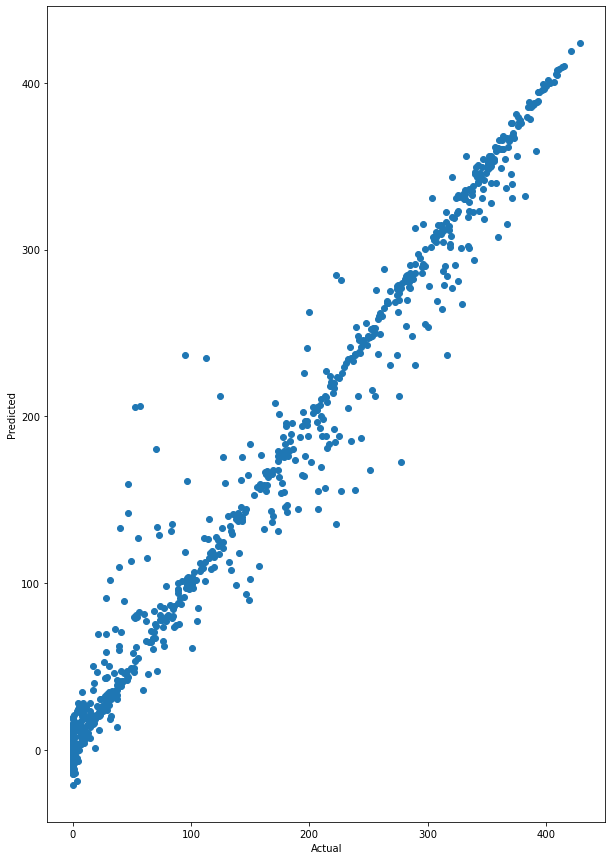

In [18]:
plt.figure(figsize = (10,15))
plt.scatter(Y_test, pred_val_optuna)
plt.xlabel('Actual')
plt.ylabel('Predicted')